uhuhuh

## Assignment 7
"Implement the convolution of a Laplacian of a Gaussian blob (LoG) detector with an image and apply it to 3-4 images of your choice from the dataset. Do not use library functions for implementing the convolution or to generate the LoG filter. Implement your own and show the code (the interesting bits at least)! The function you implement should be able to run the LoG for different choices of the scale parameter, which is passed as an input argument. Show the results of your code on the 3-4 example images, for different choices of the scale parameter (sigma)."

In [2]:
import numpy as np
import cv2 # OpenCV
import matplotlib.pyplot as plt
import seaborn as sns

img = cv2.imread('./weizmann_horse_db/horse/horse001.png', cv2.IMREAD_GRAYSCALE)

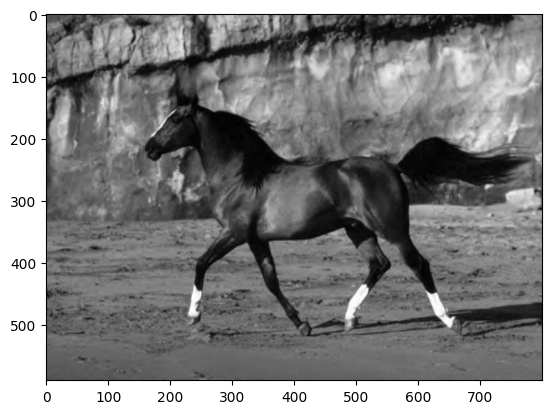

In [2]:
plt.imshow(img, cmap='gray')
plt.show()

In [3]:
#convolution
def convolution(img, kernel) -> np.ndarray:
    h1, w1 = img.shape
    h2, w2 = kernel.shape

    img = np.pad(img, (h2//2, w2//2), 'constant')

    conv_img = np.zeros((h1, w1))
    for i in range(h1):
        for j in range(w1):
            conv_img[i,j] = (img[i:i+h2 , j:j+w2] * kernel).sum()
    return conv_img


$$g(x,y,\sigma)=\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{x^2+y^2}{2\sigma^2}}$$
$$\nabla^2 g_\sigma(x,y)=\frac{\delta^2 g_\sigma}{\delta^2 x}+\frac{\delta^2 g_\sigma}{\delta^2 y}=\frac{1}{\pi \sigma^4}(\frac{x^2+y^2}{\sigma^2}-1)e^{-\frac{x^2+y^2}{2\sigma^2}}$$
DA CORREGGERE

In [4]:
def lapl(x,y,sigma):
    a = (x**2 + y**2) / (2*sigma**2)
    b=np.pi*sigma**4
    return (a - 1)*np.exp(-a)/b

#Laplacian of Gaussian
def LoG(sz, sigma) -> np.ndarray:
    kernel=np.zeros((sz,sz))
    for i in range(sz):
        for j in range(sz):
            kernel[i,j] = lapl(i-sz//2,j-sz//2,sigma)
    return kernel

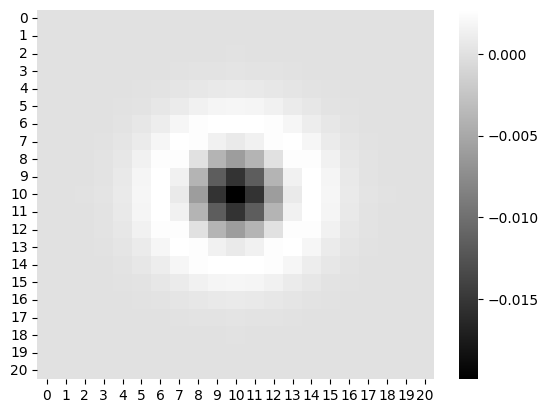

In [49]:
A=LoG(21,2)
sns.heatmap(A, cmap='gray')
plt.show()

# SBURRECK

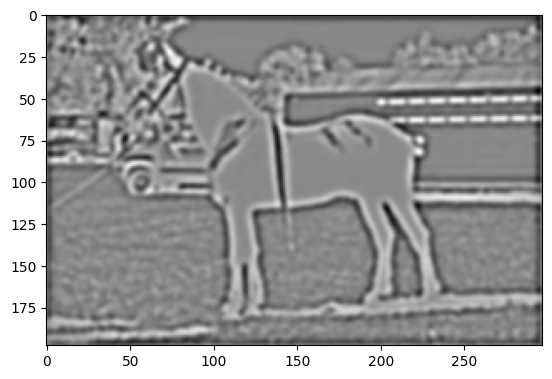

In [56]:
img = cv2.imread('./weizmann_horse_db/horse/horse003.png', cv2.IMREAD_GRAYSCALE)
modd=convolution(img, A)
plt.imshow(modd, cmap='gray')
plt.show()

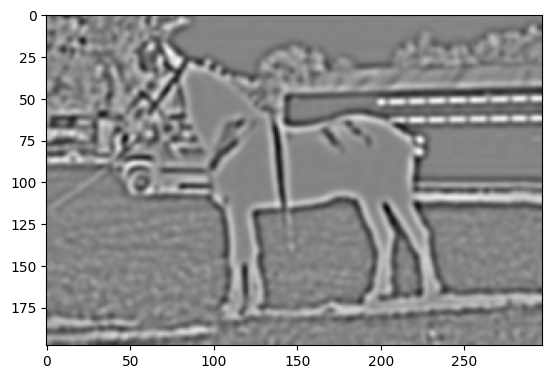

In [38]:
plt.imshow(cv2.filter2D(img/255, -1, A), cmap='gray')

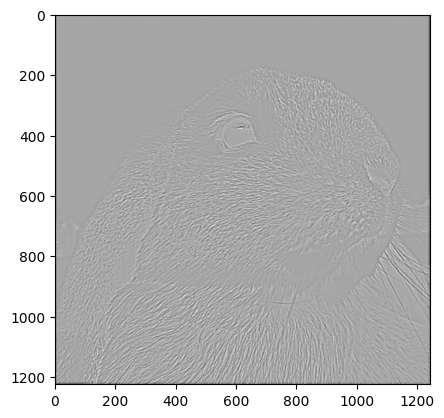

In [57]:
img = cv2.imread('./bunny001.jpg', cv2.IMREAD_GRAYSCALE)
modd=convolution(img/255, A)
plt.imshow(modd, cmap='gray')
plt.show()

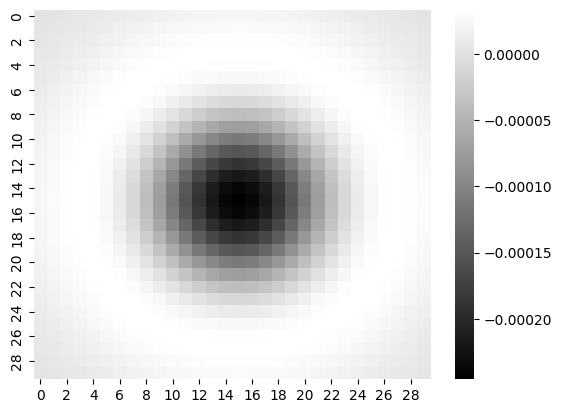

In [9]:
A=LoG(30,6)
sns.heatmap(A, cmap='gray')
plt.show()

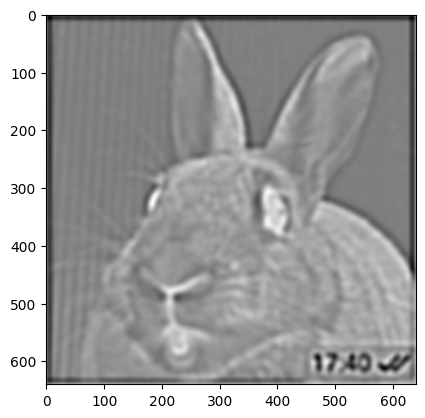

In [10]:
img = cv2.imread('./bunny002.jpg', cv2.IMREAD_GRAYSCALE)
modd=convolution(img, A)
plt.imshow(modd, cmap='gray')
plt.show()

# SBLUBBECK

In [ ]:
for i in range(200):
    